# Lab4 朴素贝叶斯
- 姓名：彭钰钊
- 学号：2110756
- 专业：计算机科学与技术
- GitHub链接：https://github.com/Yuzhao-P/Machine-Learning
    > 上传历次实验数据文件和.ipynb文件，同时在README.md中更新有关实验的相关知识整理。
## 实验要求
- 数据集  
Most Popular Data Set中的wine数据集（对意大利同一地区生产的三种不同品种的酒做大量分析所得出的数据）

### 基本要求
1. 采用分层采样的方式将数据集划分为训练集和测试集。
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

### 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

### 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

### 拓展要求
浅谈ROC曲线和AUC值作为分类评价的合理性。

***截止日期：11月17日***

- 以学号+姓名(4)的命名形式打包实验代码+实验报告发送到邮箱2120230658@mail.nankai.edu.cn
- 推荐使用.ipynb文件格式

### 导入所需要的包

In [1]:
import pandas as pd
import math
import numpy as np  
import random
import matplotlib.pyplot as plt

### 导入数据集 & 划分数据集

In [2]:
data = pd.read_csv('wine.data', header=None, sep=',')
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


我们可以看见数据第一列是三种不同品种的标识，剩下13列为酒的相关属性，由此我们可以区分标签和特征数据。
> 引自`wine.names`：【第 1 个属性为类别标识符（1-3）】

In [3]:
# 数据集划分
def split_dataset(dataset, train_ratio=0.8, random_seed=None):# 提取特征和标签
    features = np.array(dataset.drop(columns=0))  # 提取特征数据，即除了标签以外的数据
    labels = np.array(dataset[0])  # 提取标签数据
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # 辅助索引
    train_index = []
    test_index = []
    # 依照标签类别分类——{label:[该标签索引的列表]}
    label_index_dic = {}
    for i in range(len(labels)):
        # 标签类别值，即产地的标识
        label_val = labels[i]
        # 将label_val的索引放入字典中的列表内
        if label_val not in label_index_dic.keys():
            label_index_dic[label_val] = []
        label_index_dic[label_val].append(i)
    # （训练集）采样数=train_ratio*样本数，默认为4：1划分，注意取整--int强制转化；在每个标签类别中均如此
    # 分层抽样——保持数据分布的一致性，保持样本类别比例相似
    for key_label_val, label_index_list in label_index_dic.items():
        sample_amount = int(train_ratio*len(label_index_list))  # 在每个标签类别中的采样数
        sample_list = random.sample(label_index_list, sample_amount)  # 根据采样数随机在索引的列表选取，获得训练集的索引
        train_index.extend(sample_list)
    # 数据集 = 训练集 + 测试集，现在已知训练集索引，那么测试集索引不就显而易见了么
    test_index = list(set(range(len(labels))) - set(train_index))

    # 随机打乱
    random.shuffle(train_index)
    random.shuffle(test_index)

    # X -- 特征数据；y -- 标签
    # 前面我们获得的都是数据的索引，现在我们要真正获得数据——根据索引还原数据
    train_X = [features[i] for i in train_index]
    train_y = [labels[i] for i in train_index]
    test_X = [features[i] for i in test_index]
    test_y = [labels[i] for i in test_index]

    # 我们将数据与标签合并：第一列是产地标签，其余部分是特征数据
    # 产生这种冗余的原因是尝试复用Lab2的代码，这就造成了这些性能浪费的东西，虽然实现了功能
    # 事实上我们完全可以从头重新处理读取和数据结构，不过本次就这样吧
    data_train = pd.DataFrame(np.concatenate((np.array(train_y).reshape(-1,1), np.array(train_X)), axis=1))
    data_test = pd.DataFrame(np.concatenate((np.array(test_y).reshape(-1,1), np.array(test_X)), axis=1))
    
    return data_train, data_test

## 基本要求
在文件`wine.names`中说明所有属性都是连续的，那么假设其分布为高斯分布，即$P(x_d|c_k)=N(x_d|\mu_k,\sigma_𝑘^2)$  
其中，$mu_k,\sigma_𝑘^2$表示属于类𝑘的数据在属性𝑑下的均值和方差。

我们知道高斯分布的概率：
$$p(x_d|\mu_k,\sigma_k^2)=\frac{1}{\sqrt{2\pi}\sigma_k}\exp\left(-\frac{(x_d-\mu_k)^2}{2\sigma_k^2}\right)\dots[1]$$
同时可以得知先验概率：
$$p(c_k)=\frac{N_c}{N}\dots[2]$$
其中，$N_c,N$分别是类别数量以及样本总数。

那么，由公式
$$c_{MAP}=\argmax _{c_k\in C}\prod\limits _{d=1}^D P(x_d|c_k)P(c_k)\dots[3]$$
便可以预测我们的标签。

In [4]:
def Bayes(data, prior_probability, mean, std):
    p = 1
    for k in range(len(data)):
        # 公式[1]
        p *= 1 / ((2 * math.pi) ** 0.5 * std[k]) * math.exp(-((data[k] - mean[k]) ** 2) / (2 * (std[k] ** 2)))
    # 公式[3]
    p *= prior_probability
    return p

In [5]:
def Naive_Bayes_classifier(dataset):
    # 划分数据集：这里是按照原产地分层抽样
    data_train, data_test = split_dataset(dataset)
    # 首先我们需要计算三个产地类别的特征数据的均值和标准差
    # 类别分组：按照产地分组
    train_group = data_train.groupby(0)
    test_group = data_test.groupby(0)
    # 均值
    mean_1 = train_group.get_group(1).mean(axis=0)[1:].tolist()
    mean_2 = train_group.get_group(2).mean(axis=0)[1:].tolist()
    mean_3 = train_group.get_group(3).mean(axis=0)[1:].tolist()
    means = [mean_1, mean_2, mean_3]
    # 标准差
    std_1 =train_group.get_group(1).std(axis=0)[1:].tolist()
    std_2 =train_group.get_group(2).std(axis=0)[1:].tolist()
    std_3 =train_group.get_group(3).std(axis=0)[1:].tolist()
    stds = [std_1, std_2, std_3]
    # 接下来进行朴素贝叶斯分类
    # 真实产地与预测产地
    label = []
    pred = []
    err = 0
    acc = 0
    scores = [[], [], []]
    for i in range(1, 4):  # 3类
        test_data = test_group.get_group(i).values[:, 1:].tolist()
        N_c = test_group.get_group(i).shape[0] + train_group.get_group(i).shape[0]
        # 公式[2]
        prior_probability = N_c / dataset.shape[0]
        for t in test_data:
            # 暂存预测类别的概率
            tmp_label_p = []
            for l in range(3):
                tmp = Bayes(t, prior_probability, means[l], stds[l])
                tmp_label_p.append(tmp)
                # 保存概率在高级要求中使用
                scores[l].append(tmp) 
            # 选择预测概率最大的产地标签
            pred_label = tmp_label_p.index(max(tmp_label_p)) + 1
            pred.append(pred_label)
            # 此时的真实产地标签
            label.append(i)
            if pred_label != i:
                err +=1 
    acc = (np.array(pred) == np.array(label)).mean()
    return err, acc, pred, label, scores

In [6]:
err, acc, pred, label, scores = Naive_Bayes_classifier(data)
print("=====朴素贝叶斯分类器预测结果=====")
print("预测标签", pred)
print("真实标签", label)
print("错误分类 {:d} 个，准确率：{:.4f}".format(err, acc))

=====朴素贝叶斯分类器预测结果=====
预测标签 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
真实标签 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
错误分类 2 个，准确率：0.9459


## 中级要求
![Alt text](image.png)
混淆矩阵以及相关评估标准的示意图如上所示

In [7]:
def confusion_matrix(pred, label):
    confusion_mat = np.zeros((3, 3))
    for i in range(len(label)):
        confusion_mat[label[i] - 1, pred[i] - 1] += 1
    print("-----混淆矩阵-----")
    print("*******说明*******")
    print("x-predict ; y-true")
    print("******************")
    x = np.array([0, 1, 2, 3])
    y = np.array([[1], [2], [3]])
    confusion_mat = np.hstack((y, confusion_mat))
    confusion_mat = np.vstack((x, confusion_mat))
    print(confusion_mat)
    return confusion_mat

In [8]:
def evaluate(confusion_matrix):
    """
        输入参数：混淆矩阵
        输出：精度，召回率，F值
        精度 precision = confusion_matrix[x_i, y_i] / sum(confusion_matrix[x_i, y_j])[j变化]
        召回率 recall = confusion_matrix[x_i, y_i] / sum(confusion_matrix[x_j, y_i])[j变化]
        F值 F-measure = 2 / (1 / precision + 1 / recall)
    """
    precision_1 = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 2] + confusion_matrix[1, 3])
    precision_2 = confusion_matrix[2, 2] / (confusion_matrix[2, 1] + confusion_matrix[2, 2] + confusion_matrix[2, 3])
    precision_3 = confusion_matrix[3, 3] / (confusion_matrix[3, 1] + confusion_matrix[3, 2] + confusion_matrix[3, 3])
    recall_1 = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[2, 1] + confusion_matrix[3, 1])
    recall_2 = confusion_matrix[2, 2] / (confusion_matrix[1, 2] + confusion_matrix[2, 2] + confusion_matrix[3, 2])
    recall_3 = confusion_matrix[3, 3] / (confusion_matrix[1, 3] + confusion_matrix[2, 3] + confusion_matrix[3, 3])
    f_1 = 2 / (1 / precision_1 + 1 / recall_1)
    f_2 = 2 / (1 / precision_2 + 1 / recall_2)
    f_3 = 2 / (1 / precision_3 + 1 / recall_3)
    return precision_1, recall_1, f_1, precision_2, recall_2, f_2, precision_3, recall_3, f_3

In [9]:
print("=====朴素贝叶斯分类器预测结果=====")
confusion_mat = confusion_matrix(pred, label)
precision_1, recall_1, f_1, precision_2, recall_2, f_2, precision_3, recall_3, f_3 = evaluate(confusion_mat)
print("=====朴素贝叶斯分类器评价指标=====")
print("精度（precision）：\n[1]{:.4f} [2]{:.4f} [3]{:.4f}".format(precision_1, precision_2, precision_3))
print("召回率（recall）：\n[1]{:.4f} [2]{:.4f} [3]{:.4f}".format(recall_1, recall_2, recall_3))
print("F-measure：\n[1]{:.4f} [2]{:.4f} [3]{:.4f}".format(f_1, f_2, f_3))

=====朴素贝叶斯分类器预测结果=====
-----混淆矩阵-----
*******说明*******
x-predict ; y-true
******************
[[ 0.  1.  2.  3.]
 [ 1. 12.  0.  0.]
 [ 2.  0. 13.  2.]
 [ 3.  0.  0. 10.]]
=====朴素贝叶斯分类器评价指标=====
精度（precision）：
[1]1.0000 [2]0.8667 [3]1.0000
召回率（recall）：
[1]1.0000 [2]1.0000 [3]0.8333
F-measure：
[1]1.0000 [2]0.9286 [3]0.9091


## 高级要求
> https://zhuanlan.zhihu.com/p/616190701

ROC（Receiver Operating Characteristic）曲线是一种用于表示分类模型性能的图形工具。它通过将真阳性率（True Positive Rate，TPR）和假阳性率（False Positive Rate，FPR）作为横纵坐标来描绘分类器在不同阈值下的性能。  
其中真阳性率也被称为召回率，假阳性率为误诊率，计算公式为$$FPR=\frac{FP}{FP+TN}$$

AUC（Area Under the Curve）是ROC曲线下的面积，用于衡量分类器性能。AUC值越接近1，表示分类器性能越好；反之，AUC值越接近0，表示分类器性能越差。

In [10]:
def calculate_auc(tpr, fpr):
    # 计算AUC（手动积分）
    area = 0
    for i in range(1, len(fpr)):
        area += 0.5 * (tpr[i-1] + tpr[i]) * (fpr[i] - fpr[i-1])
    return area

In [11]:
def ROC_AUC(scores, labels):
    """
        scores:概率值
        labels:转化后的标签
    """
    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = labels[sorted_indices]
    
    tpr_values = []
    fpr_values = []
    
    total_positive = np.sum(labels == 1)
    total_negative = np.sum(labels == 0)
    
    true_positives = 0
    false_positives = 0
    
    for label in sorted_labels:
        if label == 1:
            true_positives += 1
        else:
            false_positives += 1
        
        tpr = true_positives / total_positive
        fpr = false_positives / total_negative
        
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    
    # 计算AUC值
    auc = calculate_auc(tpr_values, fpr_values)
    # 绘制ROC曲线
    plt.plot(fpr_values, tpr_values, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

=================================类别【1】=================================


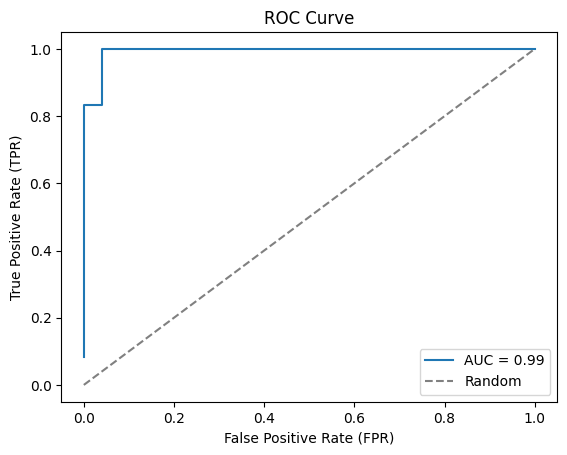

=================================类别【2】=================================


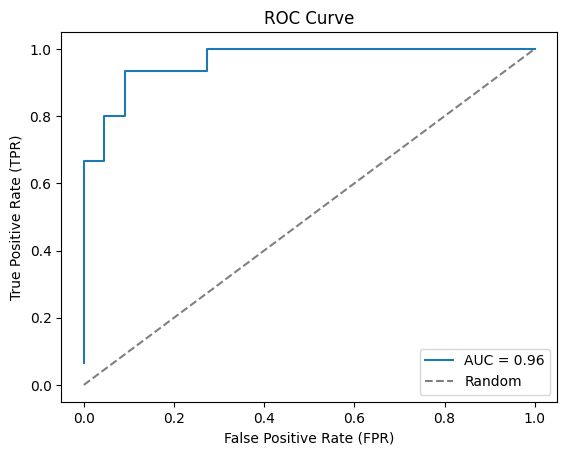

=================================类别【3】=================================


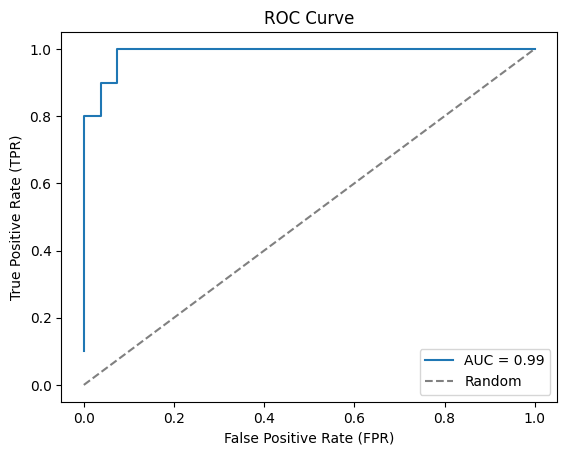

In [12]:
real_1 = [1 if x==1 else 0 for x in label]
real_2 = [1 if x==2 else 0 for x in label]
real_3 = [1 if x==3 else 0 for x in label]
print("=================================类别【1】=================================")
ROC_AUC(np.array(scores[0]),np.array(real_1))
print("=================================类别【2】=================================")
ROC_AUC(np.array(scores[1]),np.array(real_2))
print("=================================类别【3】=================================")
ROC_AUC(np.array(scores[2]),np.array(real_3))

## 拓展要求
ROC曲线（Receiver Operating Characteristic curve）和AUC值（Area Under the ROC Curve）是用于评估二分类模型性能的常用工具。

1. **对比不同模型：** ROC曲线和AUC值提供了一种比较不同分类模型的有效方式。通过比较曲线下面积（AUC值），可以很容易地确定哪个模型在不同阈值下更好地权衡了真正例和假正例。

2. **鲁棒性：** ROC曲线不受类别不平衡的影响，即使正负样本比例不同，ROC曲线仍然是有效的。这使得它成为评估在不同领域和不同数据集上的分类模型性能的强大工具。

3. **阈值不敏感：** ROC曲线对于不同阈值下的分类结果都提供了全面的信息。这对于应用程序中可能需要在不同工作点上调整阈值的情况非常有用。

4. **可视化性：** ROC曲线提供了一个直观的可视化方式来理解模型的性能。它通过展示真正例率（True Positive Rate，Sensitivity）和假正例率（False Positive Rate）之间的权衡来描述分类器的性能。

5. **AUC值的解释：** AUC值表示ROC曲线下的面积，取值范围在0到1之间。一个完美的分类器的AUC值为1，而一个随机分类器的AUC值约为0.5。因此，AUC值提供了模型在所有可能工作点上的性能总结，而不仅仅是一个点的表现。

6. **对于不同类别代价敏感：** ROC曲线和AUC值对于不同类别的代价敏感。这对于在实际应用中考虑了不同类型错误的情况下选择模型非常重要。

总体而言，ROC曲线和AUC值为我们提供了全面的工具，用于理解和比较不同分类模型的性能。然而，它们也有一些限制，例如在类别不平衡问题上的一些局限性，因此在应用时需要谨慎使用。